### Kaggle House Price Prediction

- Abstract

This paper presents a data set describing the sale of individual residential property in Ames, Iowa
from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory
variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home
values. I will discuss my previous use of the Boston Housing Data Set and I will suggest
methods for incorporating this new data set as a final project in an undergraduate regression
course.
http://jse.amstat.org/v19n3/decock.pdf

## we get the following steps for doing the prediction:

- Data Exploration
- Data Engineering
- Data Modelling
- Results
This doesn't reflect the actual process of how you take part Kaggle competitions; in reality parts 1 through to 3 are cycled through repeatedly, in varying orders, until we finally hit stage 4.

Posterity, as I will want to revisit the exact thoughts/rationales I had behind making certain choices.
Pedagogical, as it may benefit others to understand how I hacked and stumbled my way through this competition.
Of course, as much as it pains me, the process will be took me about 2 weeks 

At the time of writing, I tried to do as much of this on my own as possible, but give credit where it's due when I've adopted ideas from other Kagglers.

## Contents of project :
- Initial Data Exploration
- Create a Baseline Model
- Feature Engineering: First Pass
- Different Models
- More Data Modelling and Exploration
- Outliers (manual and statistical detection)
- Overfitting
- The FINAL engineering steps in one section
- Final Modelling
- Lasso
- Ensembled XGBoost
- Ensembled Everything

# -  Initial Data Exploration
The first step is always to read the data description if avaialble. We need to build a foundation of knowledge on which we can stand, so that we can make informed decisions further down the line. The approach I will take is relatively straightforward; look for interesting things in the data which we can test out later.

The first thing to notice is that this dataset is that there are a fair few variables. Furthermore, there seems to be categorical features listed as numbers/ordinals (MSSubClass, MoSold), and the exact opposite issue (Quality measures). We will make a note of this and see if it improves our models later.

Interestingly, it forewarns us to the presence of missing variables, which for the most case are due to a parameter not being relevant (i.e.: a one story flat will never have a properties relating to a second story).

The next thing to do is to load in the training data and understand what we will be fitting our models to.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train=pd.read_csv('train.csv')
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_test=pd.read_csv('test.csv')
df_test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
df_train.shape

(1460, 81)

In [5]:
df_test.shape

(1459, 80)

In [6]:
train_cols = df_train.columns[1:]
train_cols

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [7]:
train_cols.shape

(80,)

In [8]:
test_cols = df_test.columns[1:]
test_cols

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [9]:
test_cols.shape

(79,)

In [10]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

Colormap Viridis is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r


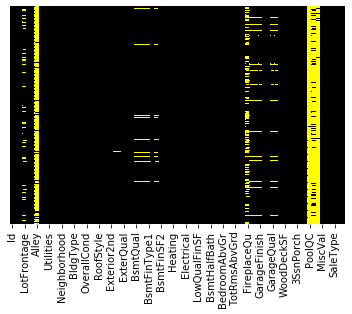

In [11]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='gnuplot')#is.null means is the data is not availble in the rows
 #to show the null value gaps in the graph

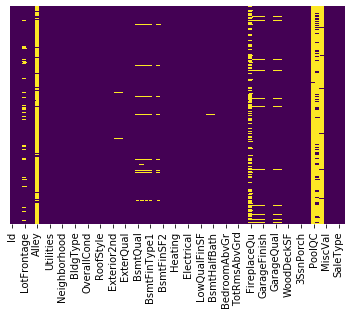

In [13]:
sns.heatmap(df_test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [14]:
numerical_feature_train = df_train.select_dtypes(include=['float64','int64'])
print('shape of numerical features train',numerical_feature_train.shape)

numerical_feature_train.head()

shape of numerical features train (1460, 38)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [15]:
numerical_feature_test = df_test.select_dtypes(include = ['float64','int64'])
print('shape of numerical features test',numerical_feature_test.shape)

numerical_feature_test.head()

shape of numerical features test (1459, 37)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,506.0,0,82,0,0,144,0,0,1,2010


In [16]:
categorical_feature_train = df_train.select_dtypes(include = 'object')
print('shape of categorical features train', categorical_feature_train.shape)

categorical_feature_train.head()

shape of categorical features train (1460, 43)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [17]:
categorical_feature_test = df_train.select_dtypes(include = 'object')
print('shape of categorical features test',categorical_feature_test.shape)

categorical_feature_test.head()

shape of categorical features test (1460, 43)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [18]:
for col in numerical_feature_train.columns:
    print('unique values for column', col, ' is: ')
    print(numerical_feature_train[col].unique())
    print(numerical_feature_train[col].nunique())  
    print()

unique values for column Id  is: 
[   1    2    3 ... 1458 1459 1460]
1460

unique values for column MSSubClass  is: 
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
15

unique values for column LotFrontage  is: 
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]
110

unique values for column LotArea  is: 
[ 8450  9600 11250 ... 17217 13175  9717]
1073

unique values for column OverallQual  is: 
[ 7  6  8  5  9  4 10  3  1  2]
10

unique values for column OverallCond  

In [19]:
df_train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [20]:
df_test.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [21]:
#checking the percentage of the missing values in the numeric training data
cwmv_numeric_train = []
for col_train in numerical_feature_train.columns:
    mv = df_train[col_train].isnull().sum()
    print('Column: ', col_train)
    mp = (mv * 100) / len(df_train)
    print('Percentage of missing values: ', mp)
    print('*' * 50)
    print()
    if (mp > 20):
        cwmv_numeric_train.append(col_train)

Column:  Id
Percentage of missing values:  0.0
**************************************************

Column:  MSSubClass
Percentage of missing values:  0.0
**************************************************

Column:  LotFrontage
Percentage of missing values:  17.73972602739726
**************************************************

Column:  LotArea
Percentage of missing values:  0.0
**************************************************

Column:  OverallQual
Percentage of missing values:  0.0
**************************************************

Column:  OverallCond
Percentage of missing values:  0.0
**************************************************

Column:  YearBuilt
Percentage of missing values:  0.0
**************************************************

Column:  YearRemodAdd
Percentage of missing values:  0.0
**************************************************

Column:  MasVnrArea
Percentage of missing values:  0.547945205479452
**************************************************

Column:  BsmtFin

In [22]:
cwmv_numeric_train

[]

In [23]:
#checking the percentage of the missing values in the numeric testing data

cwmv_numeric_test = []
for col_train in numerical_feature_test.columns:
    mv = df_train[col_train].isnull().sum()
    print('Column: ', col_train)
    mp = (mv * 100) / len(df_train)
    print('Percentage of missing values: ', mp)
    print('*' * 50)
    print()
    if (mp > 20):
        cwmv_numeric_test.append(col_train)

Column:  Id
Percentage of missing values:  0.0
**************************************************

Column:  MSSubClass
Percentage of missing values:  0.0
**************************************************

Column:  LotFrontage
Percentage of missing values:  17.73972602739726
**************************************************

Column:  LotArea
Percentage of missing values:  0.0
**************************************************

Column:  OverallQual
Percentage of missing values:  0.0
**************************************************

Column:  OverallCond
Percentage of missing values:  0.0
**************************************************

Column:  YearBuilt
Percentage of missing values:  0.0
**************************************************

Column:  YearRemodAdd
Percentage of missing values:  0.0
**************************************************

Column:  MasVnrArea
Percentage of missing values:  0.547945205479452
**************************************************

Column:  BsmtFin

In [24]:
cwmv_numeric_test

[]

In [25]:
#checking the percentage of the missing values in the categorical training data

cwmv_categorical_train = []
for col_train in categorical_feature_train.columns:
    mv_train = df_train[col_train].isnull().sum()
    print('Column : ',col_train)
    mp_train = (mv_train * 100) / len(df_train)
    print('Percentage Missing: ', mp_train)
    print('*' * 50)
    print()
    if (mp_train > 20):
        cwmv_categorical_train.append(col_train)

Column :  MSZoning
Percentage Missing:  0.0
**************************************************

Column :  Street
Percentage Missing:  0.0
**************************************************

Column :  Alley
Percentage Missing:  93.76712328767124
**************************************************

Column :  LotShape
Percentage Missing:  0.0
**************************************************

Column :  LandContour
Percentage Missing:  0.0
**************************************************

Column :  Utilities
Percentage Missing:  0.0
**************************************************

Column :  LotConfig
Percentage Missing:  0.0
**************************************************

Column :  LandSlope
Percentage Missing:  0.0
**************************************************

Column :  Neighborhood
Percentage Missing:  0.0
**************************************************

Column :  Condition1
Percentage Missing:  0.0
**************************************************

Column :  Condition

In [26]:
cwmv_categorical_train

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [27]:
#checking the percentage of the missing values in the categorical testingdata

cwmv_categorical_test = []
for col_test in categorical_feature_test.columns:
    mv_test = df_test[col_test].isnull().sum()
    print('Column : ',col_test)
    mp_test = (mv_test * 100) / len(df_test)
    print('Percentage Missing: ', mp_test)
    print('*' * 50)
    print()
    if (mp_test > 20):
        cwmv_categorical_test.append(col_test)

Column :  MSZoning
Percentage Missing:  0.27416038382453733
**************************************************

Column :  Street
Percentage Missing:  0.0
**************************************************

Column :  Alley
Percentage Missing:  92.66620973269363
**************************************************

Column :  LotShape
Percentage Missing:  0.0
**************************************************

Column :  LandContour
Percentage Missing:  0.0
**************************************************

Column :  Utilities
Percentage Missing:  0.13708019191226867
**************************************************

Column :  LotConfig
Percentage Missing:  0.0
**************************************************

Column :  LandSlope
Percentage Missing:  0.0
**************************************************

Column :  Neighborhood
Percentage Missing:  0.0
**************************************************

Column :  Condition1
Percentage Missing:  0.0
***************************************

In [28]:
cwmv_categorical_test

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [29]:
cwmv_categorical_train == cwmv_categorical_test

True

In [30]:
print('Shape of Train data before removing columns with missing values', df_train.shape)
print('Shape of Test data before removing columns with missing values', df_test.shape)

Shape of Train data before removing columns with missing values (1460, 81)
Shape of Test data before removing columns with missing values (1459, 80)


In [31]:
df_test.drop(cwmv_categorical_test, axis=1, inplace=True)
df_train.drop(cwmv_categorical_train, axis=1, inplace=True)

In [32]:
print('Shape of Train data after removing columns with missing values', df_train.shape)
print('Shape of Test data after removing columns with missing values', df_test.shape)

Shape of Train data after removing columns with missing values (1460, 76)
Shape of Test data after removing columns with missing values (1459, 75)


In [33]:
print('Shape of categorical_features_train before removing columns with missing values', categorical_feature_train.shape)
print('Shape of categorical_features_test before removing columns with missing values', categorical_feature_test.shape)

Shape of categorical_features_train before removing columns with missing values (1460, 43)
Shape of categorical_features_test before removing columns with missing values (1460, 43)


In [34]:
categorical_feature_test.drop(cwmv_categorical_test, axis=1, inplace=True)
categorical_feature_train.drop(cwmv_categorical_train, axis=1, inplace=True)

/home/madanmaram/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [35]:
print('Shape of categorical_feature_train after removing columns with missing values more than 20%:')
print(categorical_feature_train.shape)
print('Shape of categorical_feature_test after removing columns with missing values more than 20%:')
print(categorical_feature_test.shape)

Shape of categorical_feature_train after removing columns with missing values more than 20%:
(1460, 38)
Shape of categorical_feature_test after removing columns with missing values more than 20%:
(1460, 38)


In [37]:
categorical_feature_train.isnull().sum()

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       0
Functional        0
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
PavedDrive        0
SaleType          0
SaleCondition     0
dtype: int64

In [38]:
categorical_feature_test.isnull().sum()

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       0
Functional        0
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
PavedDrive        0
SaleType          0
SaleCondition     0
dtype: int64

In [39]:
categorical_feature_train = categorical_feature_train.fillna(method='ffill')#it will fill the all missing values
categorical_feature_train.isnull().sum()

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
SaleType         0
SaleCondition    0
dtype: int64

In [40]:
categorical_feature_train.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


In [48]:
df_train.isnull().values.any()# yes we got it

True

In [49]:
numerical_feature_train.shape

(1460, 38)

In [50]:
numerical_feature_test.shape

(1459, 37)

In [51]:
categorical_feature_train.shape

(1460, 38)

In [52]:
categorical_feature_test.shape

(1460, 38)

In [53]:
df_train.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
330,331,90,RL,NaN,10624,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,11,2007,WD,Normal,119000
451,452,20,RL,62.0,70761,Pave,IR1,Low,AllPub,Inside,...,0,0,0,0,0,12,2006,WD,Normal,280000
499,500,20,RL,70.0,7535,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,480,6,2007,WD,Normal,120000
634,635,90,RL,64.0,6979,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,600,6,2010,WD,Normal,144000
874,875,50,RM,52.0,5720,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2009,WD,Abnorml,66500
209,210,20,RL,75.0,8250,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,7,2008,WD,Normal,145000
832,833,60,RL,44.0,9548,Pave,IR1,Lvl,AllPub,CulDSac,...,0,0,0,0,0,1,2010,WD,Normal,237000
198,199,75,RM,92.0,5520,Pave,Reg,Lvl,AllPub,Corner,...,30,0,0,0,0,7,2009,WD,Abnorml,104000
546,547,50,RL,70.0,8737,Pave,IR1,Bnk,AllPub,Inside,...,0,144,0,0,0,5,2007,WD,Normal,210000
1075,1076,70,RL,75.0,13125,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,7,2007,CWD,Normal,219500


In [54]:
df_test.sample(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1113,2574,20,RL,70.0,18044,Pave,IR1,HLS,AllPub,CulDSac,...,64,169,0,0,228,0,8,2007,WD,Normal
1317,2778,70,RM,66.0,3960,Pave,Reg,Lvl,AllPub,Inside,...,0,68,0,0,0,0,7,2006,WD,Normal
786,2247,160,RM,21.0,1477,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,3,2008,WD,Normal
20,1481,60,RL,105.0,13650,Pave,Reg,Lvl,AllPub,Corner,...,130,0,0,0,0,0,6,2010,WD,Normal
1420,2881,50,RL,66.0,21780,Pave,Reg,Lvl,AllPub,Inside,...,0,429,0,0,0,0,9,2006,WD,Normal
1255,2716,160,FV,NaN,4447,Pave,IR1,Lvl,AllPub,FR2,...,50,0,0,0,0,0,7,2006,WD,Normal
52,1513,80,RL,NaN,10600,Pave,IR1,Lvl,AllPub,Inside,...,172,0,0,0,0,0,5,2010,COD,Family
277,1738,60,RL,NaN,11949,Pave,Reg,Lvl,AllPub,Inside,...,60,0,0,0,0,0,7,2009,WD,Normal
549,2010,60,RL,67.0,12774,Pave,Reg,Lvl,AllPub,FR2,...,68,0,0,0,0,0,7,2008,WD,Normal
1403,2864,60,RL,90.0,11060,Pave,IR1,Lvl,AllPub,Corner,...,274,0,0,0,0,0,2,2006,ConLD,Normal


In [55]:
cols_wmmv_train = []
for cols_train in df_train.columns:
    mv_train = df_train[cols_train].isnull().sum()
    print('Missing values for the column', cols_train, 'are: ', mv_train)
    mp_train = (mv_train * 100) / len(df_train) 
    print('Percentage of Missing values is: ', mp_train)
    print('*' * 50)
    print()
    if mp_train > 45:
        cols_wmmv_train.append(cols_train)

Missing values for the column Id are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column MSSubClass are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column MSZoning are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column LotFrontage are:  259
Percentage of Missing values is:  17.73972602739726
**************************************************

Missing values for the column LotArea are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column Street are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column LotShape are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column

Missing values for the column GarageCars are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column GarageArea are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column GarageQual are:  81
Percentage of Missing values is:  5.5479452054794525
**************************************************

Missing values for the column GarageCond are:  81
Percentage of Missing values is:  5.5479452054794525
**************************************************

Missing values for the column PavedDrive are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column WoodDeckSF are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column OpenPorchSF are:  0
Percentage of Missing values is:  0.0
**********************************************

In [56]:
cols_wmmv_train

[]

In [57]:
cols_wmmv_test = []
for cols_test in df_test.columns:
    mv_test = df_test[cols_test].isnull().sum()
    print('Missing values for the column', cols_test, 'are: ', mv_test)
    mp_test = (mv_test * 100) / len(df_test) 
    print('Percentage of Missing values is: ', mp_test)
    print('*' * 50)
    print()
    if mp_test > 45:
        cols_wmmv_test.append(cols_test)

Missing values for the column Id are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column MSSubClass are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column MSZoning are:  4
Percentage of Missing values is:  0.27416038382453733
**************************************************

Missing values for the column LotFrontage are:  227
Percentage of Missing values is:  15.558601782042494
**************************************************

Missing values for the column LotArea are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column Street are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column LotShape are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing valu

Missing values for the column GarageCars are:  1
Percentage of Missing values is:  0.06854009595613433
**************************************************

Missing values for the column GarageArea are:  1
Percentage of Missing values is:  0.06854009595613433
**************************************************

Missing values for the column GarageQual are:  78
Percentage of Missing values is:  5.346127484578479
**************************************************

Missing values for the column GarageCond are:  78
Percentage of Missing values is:  5.346127484578479
**************************************************

Missing values for the column PavedDrive are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column WoodDeckSF are:  0
Percentage of Missing values is:  0.0
**************************************************

Missing values for the column OpenPorchSF are:  0
Percentage of Missing values is:  0.0
****************

In [58]:
cols_wmmv_test

[]

In [59]:
print(df_train.shape)
print(df_test.shape)

(1460, 76)
(1459, 75)


In [60]:
df_train.drop(cols_wmmv_train, axis=1, inplace=True)
df_test.drop(cols_wmmv_test, axis=1, inplace=True)

In [61]:

print(df_train.shape)
print(df_test.shape)

(1460, 76)
(1459, 75)


In [62]:
df_train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 76, dtype: int64

In [63]:
df_test.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 75, dtype: int64

In [64]:
df_train.fillna(method='ffill', inplace=True)

In [65]:
df_test.fillna(method='ffill', inplace=True)

In [66]:
df_train.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 76, dtype: int64

In [67]:
df_test.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 75, dtype: int64

In [68]:
len(df_train.select_dtypes(include=['object']).iloc[:, 3].unique()) == len(df_test.select_dtypes(include=['object']).iloc[:, 3].unique())

True

In [70]:
for col in categorical_feature_train.columns:
    print('Unique values for column', col, ' is: ')
    print(categorical_feature_train[col].unique())
    print(categorical_feature_train[col].nunique())
    print()

Unique values for column MSZoning  is: 
['RL' 'RM' 'C (all)' 'FV' 'RH']
5

Unique values for column Street  is: 
['Pave' 'Grvl']
2

Unique values for column LotShape  is: 
['Reg' 'IR1' 'IR2' 'IR3']
4

Unique values for column LandContour  is: 
['Lvl' 'Bnk' 'Low' 'HLS']
4

Unique values for column Utilities  is: 
['AllPub' 'NoSeWa']
2

Unique values for column LotConfig  is: 
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
5

Unique values for column LandSlope  is: 
['Gtl' 'Mod' 'Sev']
3

Unique values for column Neighborhood  is: 
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
25

Unique values for column Condition1  is: 
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
9

Unique values for column Condition2  is: 
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
8



In [71]:
for col in categorical_feature_test.columns:
    print('Unique values for column "'+ col+ '" is: ')
    print(categorical_feature_test[col].unique())
    print(categorical_feature_test[col].nunique())
    print()

Unique values for column "MSZoning" is: 
['RL' 'RM' 'C (all)' 'FV' 'RH']
5

Unique values for column "Street" is: 
['Pave' 'Grvl']
2

Unique values for column "LotShape" is: 
['Reg' 'IR1' 'IR2' 'IR3']
4

Unique values for column "LandContour" is: 
['Lvl' 'Bnk' 'Low' 'HLS']
4

Unique values for column "Utilities" is: 
['AllPub' 'NoSeWa']
2

Unique values for column "LotConfig" is: 
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
5

Unique values for column "LandSlope" is: 
['Gtl' 'Mod' 'Sev']
3

Unique values for column "Neighborhood" is: 
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
25

Unique values for column "Condition1" is: 
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
9

Unique values for column "Condition2" is: 
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' '

In [72]:
len(df_train.select_dtypes(include=['object']).iloc[:, 4].unique())


2

In [73]:
len(df_test.select_dtypes(include=['object']).iloc[:, 4].unique())


1

In [74]:
df_train.select_dtypes(include=['object']).iloc[:, 4].unique()

array(['AllPub', 'NoSeWa'], dtype=object)

In [75]:

df_test.select_dtypes(include=['object']).iloc[:, 4].unique()

array(['AllPub'], dtype=object)

In [76]:
df_train.drop_duplicates().Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [77]:
df_test.drop_duplicates().Utilities.value_counts()

AllPub    1459
Name: Utilities, dtype: int64

In [78]:

df_train = df_train[df_train.Utilities != 'NoSeWa']

In [79]:
len(df_train.drop_duplicates().Utilities.value_counts()) == len(df_test.drop_duplicates().Utilities.value_counts())

True

In [80]:
df_train.shape

(1459, 76)

In [81]:
for i in range(1, len(df_train.columns)):
    print(i, len(df_train.select_dtypes(include=['object']).iloc[:, i].unique()) == len(df_test.select_dtypes(include=['object']).iloc[:, i].unique()))

1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 False
10 True
11 False
12 True
13 False
14 False
15 False
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 False
26 True
27 True
28 False
29 True
30 True
31 True
32 True
33 False
34 True
35 True
36 True
37 True


IndexError: single positional indexer is out-of-bounds

In [82]:

df_train.select_dtypes(include=['object']).iloc[:, 9].unique()

array(['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'],
      dtype=object)

In [83]:

df_test.select_dtypes(include=['object']).iloc[:, 9].unique()

array(['Norm', 'Feedr', 'PosA', 'PosN', 'Artery'], dtype=object)

In [84]:
df_train.drop_duplicates().Condition2.value_counts()

Norm      1444
Feedr        6
Artery       2
RRNn         2
PosN         2
RRAe         1
RRAn         1
PosA         1
Name: Condition2, dtype: int64

In [85]:
df_test.drop_duplicates().Condition2.value_counts()

Norm      1444
Feedr        7
Artery       3
PosA         3
PosN         2
Name: Condition2, dtype: int64

In [86]:
df_train = df_train[df_train.Condition2 != 'RRNn']

In [87]:

len(df_train.drop_duplicates().Condition2.value_counts()) == len(df_test.drop_duplicates().Condition2.value_counts())

False

In [88]:
df_train.shape

(1457, 76)

In [89]:
df_train.select_dtypes(include=['object']).iloc[:, 11].unique()

array(['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf',
       '2.5Fin'], dtype=object)

In [90]:
df_test.select_dtypes(include=['object']).iloc[:, 11].unique()

array(['1Story', '2Story', 'SLvl', '1.5Fin', 'SFoyer', '2.5Unf', '1.5Unf'],
      dtype=object)

In [91]:

df_train.drop_duplicates().HouseStyle.value_counts()

1Story    724
2Story    445
1.5Fin    154
SLvl       64
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [92]:

df_test.drop_duplicates().HouseStyle.value_counts()

1Story    745
2Story    427
1.5Fin    160
SLvl       63
SFoyer     46
2.5Unf     13
1.5Unf      5
Name: HouseStyle, dtype: int64

In [93]:
df_train = df_train[df_train.HouseStyle != '2.5Fin']

In [94]:
len(df_train.drop_duplicates().HouseStyle.value_counts()) == len(df_test.drop_duplicates().HouseStyle.value_counts())

True

In [105]:

df_train.shape

(1449, 76)

In [106]:
df_train.select_dtypes(include=['object']).iloc[:, 13].unique()

array(['CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv',
       'Roll', 'ClyTile'], dtype=object)

In [107]:
df_test.select_dtypes(include=['object']).iloc[:, 13].unique()

array(['CompShg', 'Tar&Grv', 'WdShake', 'WdShngl'], dtype=object)

In [108]:
df_train.drop_duplicates().RoofMatl.value_counts()

CompShg    1424
Tar&Grv      11
WdShake       5
WdShngl       5
Metal         1
Membran       1
ClyTile       1
Roll          1
Name: RoofMatl, dtype: int64

In [109]:
df_test.drop_duplicates().RoofMatl.value_counts()

CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64

In [110]:
df_train = df_train[df_train.RoofMatl != 'Membran']
df_train = df_train[df_train.RoofMatl != 'Metal']
df_train = df_train[df_train.RoofMatl != 'Roll']
df_train = df_train[df_train.RoofMatl != 'ClyTile']

In [111]:
len(df_train.drop_duplicates().RoofMatl.value_counts()) == len(df_test.drop_duplicates().RoofMatl.value_counts())

True

In [112]:
df_train.shape

(1445, 76)

In [113]:

df_train.select_dtypes(include=['object']).iloc[:, 14].unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

In [114]:
df_test.select_dtypes(include=['object']).iloc[:, 14].unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'CemntBd',
       'WdShing', 'BrkFace', 'AsbShng', 'BrkComm', 'Stucco', 'AsphShn',
       'CBlock'], dtype=object)

In [115]:
df_train.drop_duplicates().Exterior1st.value_counts()

VinylSd    514
HdBoard    221
MetalSd    217
Wd Sdng    201
Plywood    106
CemntBd     60
BrkFace     50
WdShing     26
Stucco      24
AsbShng     19
Stone        2
BrkComm      2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64

In [116]:
df_test.drop_duplicates().Exterior1st.value_counts()

VinylSd    510
MetalSd    230
HdBoard    220
Wd Sdng    205
Plywood    113
CemntBd     65
BrkFace     38
WdShing     30
AsbShng     24
Stucco      18
BrkComm      4
AsphShn      1
CBlock       1
Name: Exterior1st, dtype: int64

In [117]:
df_train = df_train[df_train.Exterior1st != 'ImStucc']
df_train = df_train[df_train.Exterior1st != 'Stone']

In [118]:
len(df_train.drop_duplicates().Exterior1st.value_counts()) == len(df_test.drop_duplicates().Exterior1st.value_counts())

True

In [119]:
df_train.shape

(1442, 76)

In [120]:

df_train.select_dtypes(include=['object']).iloc[:, 15].unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

In [121]:
df_test.select_dtypes(include=['object']).iloc[:, 15].unique()

array(['VinylSd', 'Wd Sdng', 'HdBoard', 'Plywood', 'MetalSd', 'Brk Cmn',
       'CmentBd', 'ImStucc', 'Wd Shng', 'AsbShng', 'Stucco', 'CBlock',
       'BrkFace', 'AsphShn', 'Stone'], dtype=object)

In [122]:
df_train.drop_duplicates().Exterior2nd.value_counts()

VinylSd    503
MetalSd    211
HdBoard    205
Wd Sdng    193
Plywood    139
CmentBd     59
Wd Shng     38
BrkFace     25
Stucco      25
AsbShng     19
ImStucc      9
Brk Cmn      7
Stone        4
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

In [123]:
df_test.drop_duplicates().Exterior2nd.value_counts()

VinylSd    510
MetalSd    233
HdBoard    199
Wd Sdng    194
Plywood    129
CmentBd     66
Wd Shng     43
BrkFace     22
Stucco      21
AsbShng     18
Brk Cmn     15
ImStucc      5
CBlock       2
AsphShn      1
Stone        1
Name: Exterior2nd, dtype: int64

In [124]:

df_train = df_train[df_train.Exterior2nd != 'Other']

In [125]:
len(df_train.drop_duplicates().Exterior2nd.value_counts()) == len(df_test.drop_duplicates().Exterior2nd.value_counts())

True

In [126]:

df_train.shape

(1441, 76)

In [127]:
df_train.select_dtypes(include=['object']).iloc[:, 25].unique()

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object)

In [128]:
df_test.select_dtypes(include=['object']).iloc[:, 25].unique()

array(['GasA', 'GasW', 'Grav', 'Wall'], dtype=object)

In [129]:
df_train.drop_duplicates().Heating.value_counts()


GasA     1409
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [130]:
df_test.drop_duplicates().Heating.value_counts()

GasA    1446
GasW       9
Wall       2
Grav       2
Name: Heating, dtype: int64

In [131]:
df_train = df_train[df_train.Heating != 'OthW']
df_train = df_train[df_train.Heating != 'Floor']

In [132]:

len(df_train.drop_duplicates().Heating.value_counts()) == len(df_test.drop_duplicates().Heating.value_counts())

True

In [133]:
df_train.shape

(1438, 76)

In [134]:
df_train.select_dtypes(include=['object']).iloc[:, 28].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

In [135]:
df_test.select_dtypes(include=['object']).iloc[:, 28].unique()

array(['SBrkr', 'FuseA', 'FuseF', 'FuseP'], dtype=object)

In [136]:
df_train.drop_duplicates().Electrical.value_counts()

SBrkr    1316
FuseA      91
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [137]:
df_test.drop_duplicates().Electrical.value_counts()

SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64

In [138]:
df_train = df_train[df_train.Electrical != 'Mix']

In [139]:

len(df_train.drop_duplicates().Electrical.value_counts()) == len(df_test.drop_duplicates().Electrical.value_counts())

True

In [140]:
df_train.shape

(1437, 76)

In [141]:

df_train.select_dtypes(include=['object']).iloc[:, 34].unique()

array(['TA', 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

In [142]:

df_test.select_dtypes(include=['object']).iloc[:, 34].unique()

array(['TA', 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

In [143]:
df_test.select_dtypes(include=['object']).iloc[:, 34].unique()


array(['TA', 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

In [144]:
df_train.drop_duplicates().GarageCond.value_counts()

TA    1386
Fa      33
Gd      10
Po       6
Ex       2
Name: GarageCond, dtype: int64

In [145]:

df_test.drop_duplicates().GarageCond.value_counts()


TA    1400
Fa      45
Po       7
Gd       6
Ex       1
Name: GarageCond, dtype: int64

In [146]:
df_train = df_train[df_train.GarageCond != 'Ex']

In [147]:
len(df_train.drop_duplicates().GarageCond.value_counts()) == len(df_test.drop_duplicates().GarageCond.value_counts())

False

In [148]:

df_train.shape

(1435, 76)

In [149]:

df_train.select_dtypes(include=['object'])

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


In [150]:
cols_to_transform_train  = list(df_train.select_dtypes(include=['object']).columns)

In [151]:
cols_to_transform_train

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [152]:
cols_to_transform_test = list(df_test.select_dtypes(include=['object']).columns)

In [153]:
cols_to_transform_test

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [154]:

cols_to_transform_test == cols_to_transform_train


True

In [155]:
features_dummy_train = pd.get_dummies(df_train, columns=cols_to_transform_train)


In [156]:

features_dummy_train.head()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [157]:
features_dummy_train.shape

(1435, 257)

In [158]:
features_dummy_train.drop([512], axis=0, inplace=True)

In [159]:
features_dummy_test = pd.get_dummies(df_test, columns=cols_to_transform_test)

In [160]:
features_dummy_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0
